# QPQ9 Sample

In [1]:
%matplotlib inline

In [2]:
# imports
from scipy.io import readsav as scirs
import copy, os, glob, imp
import numpy as np

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Column, Table

from xastropy.xutils import fits as xxf
from specdb.specdb import IgmSpec

from linetools import utils as ltu

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.26)

## QPQ Sample Code
Modifying lya_qpq_sample.pro in pro/data/photo

Created QPQ-CGM-IR  [Joe did]

QPQ-CGM-IR_00.000-00.300_Sat-Apr-25-21:33:45-2015.sav

### Try MgII $z_{\rm em}$ someday

## Read the Sample and Collate

In [319]:
# IDL savefile read failed..
#dat = scirs(os.getenv('DROPBOX_DIR')+'/QSOPairs/QSO-CGM-IR/QPQ-CGM-IR_00.000-00.300_Sat-Apr-25-21:33:45-2015.sav',verbose=True)
#dat

# Wrote a binary FITS table from IDL
#bgfil = 'QPQ-CGM-IR_00.000-00.300_Sat-Apr-25-21:33:45-2015_qsobg.fits.gz'
#fgfil = 'QPQ-CGM-IR_00.000-00.300_Sat-Apr-25-21:33:45-2015_qsofg.fits.gz'
#
bgfil = 'QPQ-CGM-IR_00.000-00.300_Tue-May-26-18:12:57-2015_qsobg.fits'
fgfil = 'QPQ-CGM-IR_00.000-00.300_Tue-May-26-18:12:57-2015_qsofg.fits'
#
qso_bg = xxf.bintab_to_table(os.getenv('DROPBOX_DIR')+'/QSOPairs/QPQ-CGM-IR/'+bgfil)
#
qso_fg = xxf.bintab_to_table(os.getenv('DROPBOX_DIR')+'/QSOPairs/QPQ-CGM-IR/'+fgfil)
#qso_fg[['NAME','LYA_FILE', 'Z_IR']]

x.fits.bintab_to_table: Reading /Users/lwymarie/Dropbox//QSOPairs/QPQ-CGM-IR/QPQ-CGM-IR_00.000-00.300_Tue-May-26-18:12:57-2015_qsobg.fits
x.fits.bintab_to_table: Reading /Users/lwymarie/Dropbox//QSOPairs/QPQ-CGM-IR/QPQ-CGM-IR_00.000-00.300_Tue-May-26-18:12:57-2015_qsofg.fits


In [321]:
# Collate Tables, calculate R_perp
qpq9 = copy.deepcopy(qso_bg)
# Add/replce key columns from qso_fg
oldc = ['Z_IR','SIGMA_ZIR', 'RA', 'DEC']
newc = ['FG_ZIR', 'FG_SIG_ZIR', 'FG_RA', 'FG_DEC']
for jj,ioldc in enumerate(oldc):
    tmpc = Column( qso_fg[ioldc], name=newc[jj])
    #print newc[jj]
    qpq9.add_column( tmpc )
# 
qpq9['G_UV'] = qso_fg['G_UV']
qpq9.add_column( Column( qso_bg['Z_TOT'], name='BG_Z') )
len(qpq9)

34

### Rphys

In [322]:
# Coordinates
c_fg = SkyCoord(ra=qpq9['FG_RA']*u.deg, dec=qpq9['FG_DEC']*u.deg)
c_bg = SkyCoord(ra=qpq9['RA']*u.deg, dec=qpq9['DEC']*u.deg)
# Separation
kpc_amin = cosmo.kpc_proper_per_arcmin( qpq9['FG_ZIR'] ) # kpc per arcmin
ang_sep = c_fg.separation(c_bg).to('arcmin')
Rphys = kpc_amin * ang_sep
# Add
if 'R_PHYS' not in qpq9.dtype.names:
    qpq9.add_column(Column( Rphys, name='R_PHYS'))
#qpq9[['NAME', 'RA', 'DEC', 'R_PHYS', 'LYA_FILE', 'FG_ZIR']][0:3]
#xdb.xhist(qpq9['R_PHYS'].value)

## Cuts

In [331]:
# Lya beta
zLya_beta = (qpq9['BG_Z']+1)*1025.7223 / 1215.6701 - 1
dv_beta = ltu.v_from_z(qpq9['FG_ZIR'], zLya_beta)
gd_beta = dv_beta > (-500*u.km/u.s)
#
qpq9 = qpq9[gd_beta]
print('We have {:d} pairs in QPQ9'.format(len(qpq9)))
#xdb.xpcol(zLya_beta, qpq9['FG_ZIR'], qpq9['BG_Z'])

We have 33 pairs in QPQ9


(['RUN',
  'RERUN',
  'CAMCOL',
  'FIELD',
  'ID',
  'PARENT',
  'NCHILD',
  'OBJC_TYPE',
  'OBJC_PROB_PSF',
  'OBJC_FLAGS',
  'OBJC_FLAGS2',
  'OBJC_ROWC',
  'OBJC_ROWCERR',
  'OBJC_COLC',
  'OBJC_COLCERR',
  'ROWV',
  'ROWVERR',
  'COLV',
  'COLVERR',
  'ROWC',
  'ROWCERR',
  'COLC',
  'COLCERR',
  'PSFCOUNTSERR',
  'FIBERCOUNTSERR',
  'FIBER2COUNTSERR',
  'PETROCOUNTSERR',
  'PETRORAD',
  'PETRORADERR',
  'PETROR50',
  'PETROR50ERR',
  'PETROR90',
  'PETROR90ERR',
  'Q',
  'QERR',
  'U',
  'UERR',
  'M_E1',
  'M_E2',
  'M_E1E1ERR',
  'M_E1E2ERR',
  'M_E2E2ERR',
  'M_RR_CC',
  'M_RR_CCERR',
  'M_CR4',
  'M_E1_PSF',
  'M_E2_PSF',
  'M_RR_CC_PSF',
  'M_CR4_PSF',
  'ISO_ROWC',
  'ISO_ROWCERR',
  'ISO_ROWCGRAD',
  'ISO_COLC',
  'ISO_COLCERR',
  'ISO_COLCGRAD',
  'ISO_A',
  'ISO_AERR',
  'ISO_AGRAD',
  'ISO_B',
  'ISO_BERR',
  'ISO_BGRAD',
  'ISO_PHIGRAD',
  'R_DEV',
  'R_DEVERR',
  'AB_DEV',
  'AB_DEVERR',
  'COUNTS_DEVERR',
  'R_EXP',
  'R_EXPERR',
  'AB_EXP',
  'AB_EXPERR',
  'COUNTS_E

## Write

In [25]:
# Don't write. The current qpq9_zIR.fits made by Joe/X have more columns then what the code above gives. 
#xxf.table_to_fits(qpq9, 'qpq9_zIR.fits')

# Make a new sample merging QPQ9_zIR and QPQ7 cut for MgII and 300 kpc

In [32]:
zIR_fil = 'qpq9_zIR.fits'
QPQ7_fil = imp.find_module('enigma')[1] + '/data/qpq/qpq7_pairs.fits.gz'
QPQ_zIR = xxf.bintab_to_table(zIR_fil)
QPQ7 = xxf.bintab_to_table(QPQ7_fil)

x.fits.bintab_to_table: Reading qpq9_zIR.fits
x.fits.bintab_to_table: Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq7_pairs.fits.gz


In [50]:
c = SkyCoord(QPQ_zIR['FG_RA']*u.deg,QPQ_zIR['FG_DEC']*u.deg)
c.to_string('hmsdms')[26]
QPQ_zIR['ZEM','Z_TOT','FG_ZIR'][26]

ZEM,Z_TOT,FG_ZIR
float32,float64,float64
2.33995,2.33995008469,2.2750001


In [15]:
new_qpq9 = copy.deepcopy(QPQ_zIR)
new_qpq9.rename_column('FG_ZIR', 'Z_FG')
new_qpq9.rename_column('FG_SIG_ZIR','Z_FSIG')
for ii,qq in enumerate(new_qpq9):
    try:
        assert 'J1433+0641' in qq['NAME'] # redshift is Null in the zIR structure 
        new_qpq9.remove_row(ii)
        break
    except AssertionError:
        pass
len(new_qpq9)

31

In [16]:
c_QPQzIR = SkyCoord(ra=QPQ_zIR['FG_RA']*u.deg, dec=QPQ_zIR['FG_DEC']*u.deg)
c_QPQ7 = SkyCoord(ra=QPQ7['RAD']*u.deg, dec=QPQ7['DECD']*u.deg)
c_QPQ7_bg = SkyCoord(ra=QPQ7['RAD_BG']*u.deg,dec=QPQ7['DECD_BG']*u.deg)
kpc_amin = cosmo.kpc_proper_per_arcmin(QPQ7['Z_FG'])
ang_sep = c_QPQ7.separation(c_QPQ7_bg).to('arcmin')
                                          
for qq,cc in enumerate(c_QPQ7):
    # do not copy the entry with wrong spectral file 
    wrong_c = SkyCoord(ra=8.59753707028004*u.deg,dec=-10.832307685613417*u.deg)
    if c_QPQ7_bg[qq].separation(wrong_c).to('arcsec') < 0.5*u.arcsec:
        continue
    if len(np.where(cc.separation(c_QPQzIR).to('arcsec') < 0.5*u.arcsec)[0]) == 0:
        if kpc_amin[qq]*ang_sep[qq] < 300*u.kpc:
            if QPQ7['Z_FSIG'][qq] < 300:
                new_qpq9.add_row({'FG_RA':QPQ7['RAD'][qq],'FG_DEC':QPQ7['DECD'][qq],'NAME':QPQ7['QSO_BG'][qq],
                        'RA':QPQ7['RAD_BG'][qq],'DEC':QPQ7['DECD_BG'][qq],'Z_FG':QPQ7['Z_FG'][qq],'Z_FSIG':272,
                        'BG_Z':QPQ7['Z_BG'][qq],'R_PHYS':QPQ7['R_PHYS'][qq],'ZFG_LINE':'MgII'})

new_qpq9.sort(['FG_RA','FG_DEC'])

In [17]:
# write
xxf.table_to_fits(new_qpq9,'qpq9_final.fits')
len(new_qpq9)

55

In [10]:
new_qpq9['RA','DEC','NAME','ZFG_LINE'][0:100]

RA,DEC,NAME,ZFG_LINE
float64,float64,str14,str36
14.3287633684,-0.0263108702349,BOSSJ0057-0001,[OIII]
27.3227662484,-0.366242429577,SDSSJ0149-0021,MgII
36.3312696693,0.806583821575,BOSSJ0225+0048,[OII]
37.5832882888,-3.55444111362,BOSSJ0230-0333,MgII
55.4133096521,-0.00353495681141,SDSSJ0341-0000,MgII
62.4758752949,-4.19363997107,SDSSJ0409-0411,MgII
118.246405235,40.1884027001,SDSSJ0752+4011,MgII
120.20306832,35.7086976546,APOJ0800+3542,[OIII]
127.186963574,45.7550664137,SDSSJ0828+4545,MgII


# New XSHOOTER redshifts 

In [18]:
new_qpq9 = xxf.bintab_to_table('qpq9_final.fits')
c_newqpq9 = SkyCoord(new_qpq9['FG_RA']*u.deg,new_qpq9['FG_DEC']*u.deg)

x.fits.bintab_to_table: Reading qpq9_final.fits


In [19]:
zem_fil = glob.glob(os.getenv('DROPBOX_DIR')+'Marie_Enrico/papers/QPQ9/Analysis/Redshifts/zem/*')
zsys_line = ['H$\\alpha$','H$\\beta$','MgII','[OIII]']
igmsp = IgmSpec()
ID_fg,ID_bg = igmsp.pairs(0.69*u.arcmin, 3000.*u.km/u.s)
c_igmsp = SkyCoord(igmsp.cat['RA'][ID_fg]*u.deg,igmsp.cat['DEC'][ID_fg]*u.deg)
c_igmsp_bg = SkyCoord(igmsp.cat['RA'][ID_bg]*u.deg,igmsp.cat['DEC'][ID_bg]*u.deg)
for ff in zem_fil:
    zem = xxf.bintab_to_table(ff)
    ipos1 = zem['SPEC_FIL'][0].rfind('/SDSSJ')+6
    ipos2 = zem['SPEC_FIL'][0].rfind('_F_zem.fits')-9
    radec = zem['SPEC_FIL'][0][ipos1:ipos2]
    RA = radec[0:2]+'h'+radec[2:4]+'m'+radec[4:9]+'s'
    dec = radec[9:12]+'d'+radec[12:14]+'m'+radec[14:18]+'s'
    zem_coord = SkyCoord(RA,dec)
    print(zem_coord.to_string('hmsdms'))
    if '09h13m38.3s -01d07m08.7s' in zem_coord.to_string('hmsdms'):
        # redshift is Null in the zIR structure 
        for ii,qq in enumerate(new_qpq9):
            try:
                assert 'J0913-0107' in qq['NAME'] 
                qq['Z_FG'] = zem['ZSYS_ZSYS'][0]
                qq['Z_FSIG'] = np.rint(zem['ZSYS_ERR'][0])
                qq['ZFG_LINE'] = zsys_line[np.min([zem['ZSYS_FLAG'][0],3])]
                break
            except AssertionError:
                pass
    if '12h31m43.09s +00d28m46.2s' in zem_coord.to_string('hmsdms'):
        # in QPQ7, not in QPQ9 yet 
        index = np.where(zem_coord.separation(c_QPQ7) < 5*u.arcsec)[0]
        new_qpq9.add_row({'FG_RA':QPQ7['RAD'][index],'FG_DEC':QPQ7['DECD'][index],'NAME':QPQ7['QSO_BG'][index],
                          'RA':QPQ7['RAD_BG'][index],'DEC':QPQ7['DECD_BG'][index],
                          'Z_FG':zem['ZSYS_ZSYS'][0],'Z_FSIG':np.rint(zem['ZSYS_ERR'][0]),
                          'BG_Z':QPQ7['Z_BG'][index],'R_PHYS':QPQ7['R_PHYS'][index],
                          'ZFG_LINE':zsys_line[np.min([zem['ZSYS_FLAG'][0],3])]})
    if '14h33m45.5s +06d41m10s' in zem_coord.to_string('hmsdms') or '23h38m45.19s -00d03m27.2s' in zem_coord.to_string('hmsdms'):
        # in igmspec, not in QPQ9 yet
        index = np.where(zem_coord.separation(c_igmsp) < 5*u.arcsec)[0]
        kpc_amin = cosmo.kpc_proper_per_arcmin(igmsp.cat['zem'][ID_fg][index]) # kpc per arcmin
        ang_sep = c_igmsp[index].separation(c_igmsp_bg[index])*60*u.arcmin/u.deg
        name = 'BOSSJ'
        name = name + c_igmsp_bg[index][0].to_string('hmsdms')[0:2] + c_igmsp_bg[index][0].to_string('hmsdms')[3:5]
        ipos = c_igmsp_bg[index][0].to_string('hmsdms').rfind(' ')+1
        name = name + c_igmsp_bg[index][0].to_string('hmsdms')[ipos:ipos+3] + c_igmsp_bg[index][0].to_string('hmsdms')[ipos+4:ipos+6]
        new_qpq9.add_row({'FG_RA':c_igmsp[index][0].ra.degree,'FG_DEC':c_igmsp[index][0].dec.degree,'NAME':name,
                         'RA':c_igmsp_bg[index][0].ra.degree,'DEC':c_igmsp_bg[index][0].dec.degree,
                         'Z_FG':zem['ZSYS_ZSYS'][0],'Z_FSIG':np.rint(zem['ZSYS_ERR'][0]),
                         'BG_Z':igmsp.cat['zem'][ID_bg][index][0],'R_PHYS':kpc_amin[0]*ang_sep[0]/u.kpc,
                         'ZFG_LINE':zsys_line[np.min([zem['ZSYS_FLAG'][0],3])]})
new_qpq9.sort(['FG_RA','FG_DEC'])

Using /Users/lwymarie/Desktop/IGMspec_DB_v02.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/IGMspec_DB_v02.hdf5 for the DB file
Available surveys: [u'BOSS_DR12', u'HSTQSO', u'SDSS_DR7', u'KODIAQ_DR1', u'MUSoDLA', u'HD-LLS_DR1', u'2QZ', u'ESI_DLA', u'HDLA100', u'GGG', u'COS-Halos', u'HST_z2', u'COS-Dwarfs', u'XQ-100']
Database is igmspec
Created on 2016-Oct-25
x.fits.bintab_to_table: Reading /Users/lwymarie/Dropbox/Marie_Enrico/papers/QPQ9/Analysis/Redshifts/zem/SDSSJ091338.30-010708.7_F_zem.fits
09h13m38.3s -01d07m08.7s
x.fits.bintab_to_table: Reading /Users/lwymarie/Dropbox/Marie_Enrico/papers/QPQ9/Analysis/Redshifts/zem/SDSSJ123143.09+002846.2_F_zem.fits
12h31m43.09s +00d28m46.2s
x.fits.bintab_to_table: Reading /Users/lwymarie/Dropbox/Marie_Enrico/papers/QPQ9/Analysis/Redshifts/zem/SDSSJ143345.50+064110.0_F_zem.fits
14h33m45.5s +06d41m10s
x.fits.bintab_to_table: Reading /Users/lwymarie/Dropbox/Marie_Enrico/papers/QPQ9/Analysis/Redshifts/zem/SDSSJ233845.19-000327.2_F_zem.fits

In [20]:
# write
xxf.table_to_fits(new_qpq9, 'qpq9_final.fits')
len(new_qpq9)

58

# Add igmspec QSO pairs with HW10 redshifts 

In [28]:
# Load the different catalogs 
igmsp = IgmSpec()
ID_fg, ID_bg = igmsp.pairs(0.92*u.arcmin, 3000.*u.km/u.s) # at z = 0.4, 0.92' = 300 kpc
c_igmsp = SkyCoord(igmsp.cat['RA'][ID_fg]*u.deg,igmsp.cat['DEC'][ID_fg]*u.deg,frame='icrs')
c_igmsp_bg = SkyCoord(igmsp.cat['RA'][ID_bg]*u.deg,igmsp.cat['DEC'][ID_bg]*u.deg,frame='icrs')
kpc_amin = cosmo.kpc_proper_per_arcmin(igmsp.cat['zem'][ID_fg])
ang_sep = c_igmsp.separation(c_igmsp_bg).to('arcmin')

myers = Table(igmsp.idb.hdf['quasars'].value)
c_myers = SkyCoord(myers['RA']*u.deg,myers['DEC']*u.deg,frame='icrs')

QPQ9 = xxf.bintab_to_table('qpq9_final.fits')
c_QPQ9 = SkyCoord(QPQ9['FG_RA']*u.deg,QPQ9['FG_DEC']*u.deg,frame='icrs')
c_QPQ9_bg = SkyCoord(ra=QPQ9['RA']*u.deg,dec=QPQ9['DEC']*u.deg)

Using /Users/lwymarie/Desktop/IGMspec_DB_v02.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/IGMspec_DB_v02.hdf5 for the DB file
Available surveys: [u'BOSS_DR12', u'HSTQSO', u'SDSS_DR7', u'KODIAQ_DR1', u'MUSoDLA', u'HD-LLS_DR1', u'2QZ', u'ESI_DLA', u'HDLA100', u'GGG', u'COS-Halos', u'HST_z2', u'COS-Dwarfs', u'XQ-100']
Database is igmspec
Created on 2016-Oct-25
x.fits.bintab_to_table: Reading qpq9_final.fits


In [31]:
igmsp.cat['zem'][ID_fg[0]],igmsp.cat['zem'][ID_bg[0]]

(1.5767871388786463, 2.7800567771399662)

In [41]:
c_bg_sorted = copy.deepcopy(c_igmsp_bg)
c_bg_sorted.ra.sort()
c_bg_sorted.ra.deg[1:100]
c_fg_sorted = copy.deepcopy(c_igmsp)
c_fg_sorted.ra.sort()
c_fg_sorted.ra.deg[1:100]

array([ 0.24605309,  0.34757165,  0.354768  ,  0.36691473,  0.47647179,
        0.48912201,  0.49583333,  0.579626  ,  0.62899647,  0.68083455,
        0.72798194,  0.817998  ,  0.85552545,  1.02977806,  1.06010137,
        1.07041667,  1.23403894,  1.253513  ,  1.36798882,  1.424536  ,
        1.68968052,  1.76227486,  1.79495545,  1.905     ,  1.92741246,
        2.017612  ,  2.021589  ,  2.13391569,  2.16923339,  2.23221006,
        2.25858948,  2.26116021,  2.29366667,  2.300746  ,  2.3619725 ,
        2.37911925,  2.44582357,  2.48477215,  2.48572464,  2.54243424,
        2.57223797,  2.59081126,  2.61993575,  2.66826272,  2.81625611,
        2.83428385,  2.84692426,  2.94195   ,  3.01893545,  3.05310989,
        3.238559  ,  3.29211254,  3.42745766,  3.43349615,  3.44005658,
        3.76045833,  3.88524245,  3.90554167,  3.939006  ,  3.99497251,
        4.02453087,  4.02736419,  4.05658333,  4.08486532,  4.237507  ,
        4.24361007,  4.298186  ,  4.36258333,  4.39895619,  4.59

In [132]:
cosmo.kpc_proper_per_arcmin(0.4)*0.92*u.arcmin

<Quantity 300.0272802178239 kpc>

In [49]:
for qq,cc in enumerate(c_igmsp):
    if kpc_amin[qq]*ang_sep[qq] < 300 *u.kpc: 
        if len(np.where(cc.separation(c_QPQ9) < 5*u.arcsec)[0]) == 0: # not in QPQ9 yet 
            if len(np.where(cc.separation(c_myers) < 5*u.arcsec)[0]) > 0: # in Myers 
                # Checked no two close by sources both have HW10 redshifts  
                # Checked HW10 redshifts are always the first returned result 
                if myers['ZEM_SOURCE'][np.where(cc.separation(c_myers) < 5*u.arcsec)[0][0]] == 'SDSS-HW': # good z
                    # MgII redshift or better
                    if myers['ZEM'][np.where(cc.separation(c_myers) < 5*u.arcsec)[0][0]] <= 2.1: 
                        # Match Johnson+15 and Farina+ samples
                        if myers['ZEM'][np.where(cc.separation(c_myers) < 5*u.arcsec)[0][0]] >= 0.4: 
                            # Lya forest cut for MgII stack  
                            if 2796.352*(1+igmsp.cat['zem'][ID_fg][qq]) > (1215.6701+6.)*(1+igmsp.cat['zem'][ID_bg][qq]):
                                if np.mod(igmsp.cat['flag_survey'][ID_fg][qq],2) == 0:
                                    name = 'BOSSJ'
                                else:
                                    name = 'SDSSJ'  
                                name = name + c_igmsp_bg[qq].to_string('hmsdms')[0:2]
                                name = name + c_igmsp_bg[qq].to_string('hmsdms')[3:5]
                                ipos = c_igmsp_bg[qq].to_string('hmsdms').rfind(' ')+1
                                name = name + c_igmsp_bg[qq].to_string('hmsdms')[ipos:ipos+3] 
                                name = name + c_igmsp_bg[qq].to_string('hmsdms')[ipos+4:ipos+6]
                                QPQ9.add_row({'FG_RA':igmsp.cat['RA'][ID_fg][qq],
                                                  'FG_DEC':igmsp.cat['DEC'][ID_fg][qq],
                                                  'NAME':name,
                                                  'RA':igmsp.cat['RA'][ID_bg][qq],
                                                  'DEC':igmsp.cat['DEC'][ID_bg][qq],
                                                  'Z_FG':igmsp.cat['zem'][ID_fg][qq],
                                                  'Z_FSIG':272,
                                                  'BG_Z':igmsp.cat['zem'][ID_bg][qq],
                                                  'R_PHYS':kpc_amin[qq]*ang_sep[qq]/u.kpc,
                                                  'ZFG_LINE':'SDSS-HW'})
QPQ9.sort(['FG_RA','FG_DEC'])

In [370]:
# save and copy to enigma
xxf.table_to_fits(QPQ9,'qpq9_final.fits')
!cp qpq9_final.fits /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits

In [51]:
QPQ9 = xxf.bintab_to_table('/Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits')
index = np.where((QPQ9['Z_FG'] >= 1.6))
c = SkyCoord(QPQ9['FG_RA'][index]*u.deg,QPQ9['FG_DEC'][index]*u.deg)
c.to_string('hmsdms')

x.fits.bintab_to_table: Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits


[u'00h01m25.1443s +00d00m09.4356s',
 u'00h08m04.2269s -00d39m22.9824s',
 u'00h08m05.1814s -00d39m46.782s',
 u'00h42m38.2385s +13d50m54.8052s',
 u'00h47m57.2575s +14d47m41.9604s',
 u'00h57m17.3646s -00d01m13.3303s',
 u'01h03m23.8409s -00d02m54.204s',
 u'01h06m16.3968s +00d56m56.85s',
 u'01h49m17.1049s -00d21m41.6461s',
 u'01h54m48.9377s +00d20m42.774s',
 u'02h14m16.9579s -00d52m29.1468s',
 u'02h24m47.8961s -00d47m00.3552s',
 u'02h25m17.6801s +00d48m21.966s',
 u'02h25m26.3271s -01d14m34.3976s',
 u'02h30m18.2659s -03d33m19.4168s',
 u'02h32m26.5389s -00d11m45.1292s',
 u'02h42m57.2066s -00d45m49.5072s',
 u'02h46m03.6827s -00d32m11.7543s',
 u'02h50m38.6916s -00d47m39.1056s',
 u'03h34m44.0342s -00d58m26.1984s',
 u'03h41m38.1578s +00d00m02.9332s',
 u'04h09m55.872s -04d11m26.9365s',
 u'07h49m54.1073s +37d02m16.7676s',
 u'07h52m59.8146s +40d11m28.2199s',
 u'08h00m49.8934s +35d42m49.6331s',
 u'08h09m45.1728s +45d39m18.108s',
 u'08h12m23.1689s +26d20m00.906s',
 u'08h14m27.2102s +04d02m29.1336s',
 

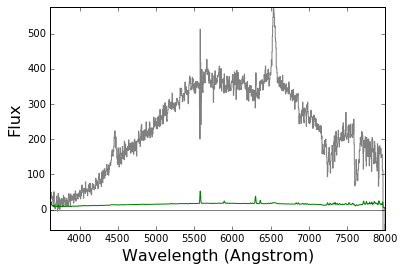

In [212]:
specs[0].plot()

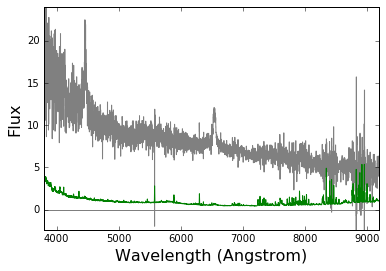

In [214]:
[specs[1].plot()]